## `Data Preparation`

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Packages:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score


In [6]:
train_df = pd.read_csv('Data/train.csv')

In [7]:
train_df.head(2)

,Unnamed: 0,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0,7590-VHVEG,Female,0,Yes,No,1,No,NaN,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No


In [8]:
train_df.drop(columns=['customerid','Unnamed: 0'], axis = 1, inplace = True)

In [9]:
train_df.head(2)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No


In [10]:
train_df.isna().sum()

gender                0
seniorcitizen         0
partner               0
dependents            0
tenure                0
phoneservice          0
multiplelines       269
internetservice       0
onlinesecurity      651
onlinebackup        651
deviceprotection    651
techsupport         651
streamingtv         651
streamingmovies     651
contract              0
paperlessbilling      0
paymentmethod         0
monthlycharges        0
totalcharges          8
churn                 1
dtype: int64

#### To prevent data leakage, drop row with missing value in the churn column

In [11]:
train_df.dropna(subset='churn', inplace=True)

#### Check if the target variable is balanced

In [12]:
churn_distribution = train_df['churn'].value_counts().rename('total').reset_index()
churn_distribution

,churn,total
0,No,3706
1,Yes,1336


- Visualize the churn distribution

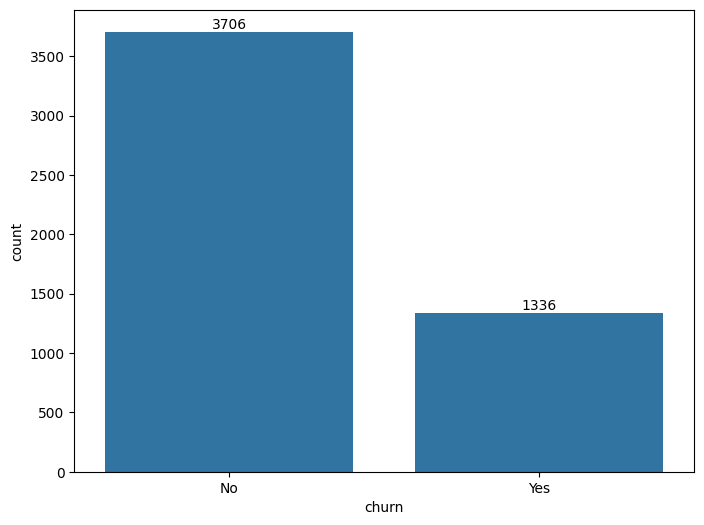

In [13]:
# Create the figure
plt.figure(figsize=(8, 6))

ax=sns.countplot(train_df, x='churn')

# Add count values on top of each bar
for p in ax.patches:
    count = int(p.get_height())  # Convert count to integer
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

#### Splitting the data into X and y variables

In [14]:
X = train_df.drop('churn', axis =1)
y = train_df[['churn']]

In [15]:
# DATA LEAKAGE ISSUES??? Do imputations only after train_test_split and only on y_train
# y_imputer = SimpleImputer(strategy='most_frequent', missing_values= pd.NA)
 
# y_imputed = y_imputer.fit_transform(y)
 
# y_imputed = pd.DataFrame(y_imputed, columns=y.columns)

In [16]:

# X_train_, X_eval_, y_train, y_eval =  train_test_split(X, y_imputed, test_size=0.2, random_state=42, stratify=y_imputed)

#### Splitting X and y into train and eval

In [17]:
X_train, X_eval, y_train, y_eval =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Encode y train and eval using Label encoder

In [18]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train['churn'])
y_eval_encoded = encoder.transform(y_eval['churn'])


### Preparing Pipelines

In [19]:
numerical_columns = X.select_dtypes('number').columns
categorical_columns = X.select_dtypes('object').columns

In [20]:
numerical_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy = 'median')),
    ('num_scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('cat-encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

### Modelling

In [90]:
from sklearn.ensemble import AdaBoostClassifier

models =[
    ('Decision_tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic_reg', LogisticRegression(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('random_forest', RandomForestClassifier(random_state = 42)),
    
]

# Creating dictionary for the models
all_pipelines = {}

# Create an empty DataFrame for metrics
metrics_table = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall', 'f1_score'])

# Loop over models and create pipelines, fit models, and calculate metrics
for model_name, classifier in models:
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Fit the pipeline on training data
    final_pipeline.fit(X_train, y_train_encoded)
    
    # Make predictions on the evaluation dataset
    y_pred = final_pipeline.predict(X_eval)

    # Calculate classification report metrics
    metrics = classification_report(y_eval_encoded, y_pred, output_dict=True)

    # Add all pipelines into all_pipeline dictionary
    all_pipelines[model_name] = final_pipeline
    
    # Extract metrics for the current model
    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1_score = metrics['weighted avg']['f1-score']
    
    # Add metrics to metrics_table
    metrics_table.loc[len(metrics_table)] = [model_name, accuracy, precision, recall, f1_score]

# Display the metrics table
metrics_table.sort_values(ascending=False, by='f1_score')

,model_name,accuracy,precision,recall,f1_score
1,Logistic_reg,0.799802,0.794989,0.799802,0.796963
3,random_forest,0.786918,0.776866,0.786918,0.779906
2,knn,0.765114,0.764275,0.765114,0.764687
0,Decision_tree,0.723489,0.731998,0.723489,0.727303


In [91]:
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat-encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [92]:
from sklearn.metrics import classification_report, confusion_matrix

all_confusion_matrix = {}

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_eval_encoded, y_pred)

all_confusion_matrix[model_name] = conf_matrix

In [93]:
all_confusion_matrix

{'random_forest': array([[658,  84],
        [131, 136]], dtype=int64)}

<Axes: >

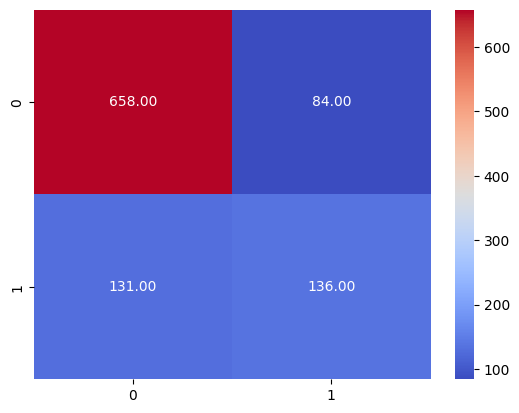

In [94]:
forest_matrix = all_confusion_matrix['random_forest']
sns.heatmap(forest_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')

#### Visualizing the ROC_AUC curve

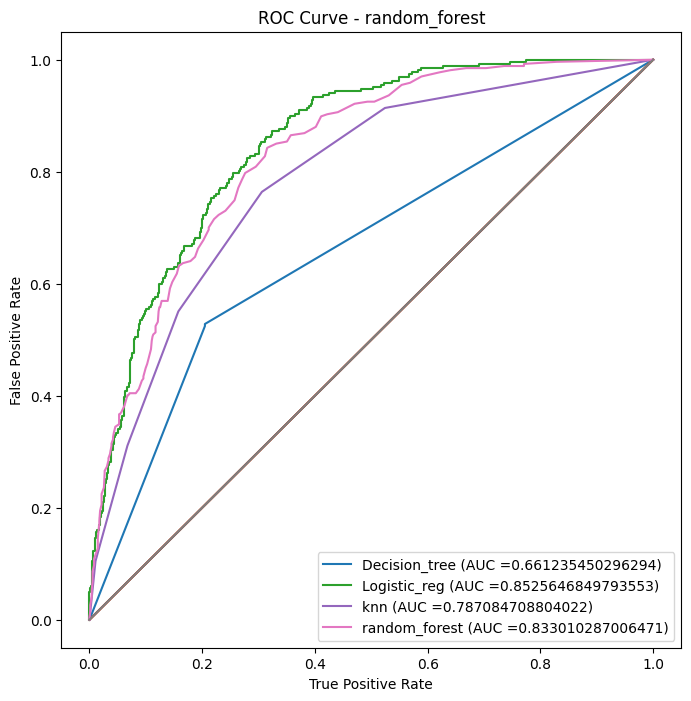

In [95]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize = (8,8))

# add confusion matrix to all pipelines
all_confusion_matrix = {}

all_roc_data = {}

for model_name, pipeline in all_pipelines.items():
    y_score = pipeline.predict_proba(X_eval)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_eval_encoded, y_score)

    roc_auc = auc(fpr, tpr)

    roc_data_df = pd.DataFrame({'False Positive rate': fpr, 'True Positive Rate': tpr, 'Thresholds': thresholds})

    all_roc_data[model_name] = roc_data_df

    ax.plot(fpr, tpr, label= f'{model_name} (AUC ={roc_auc})')

    ax.plot([0,1], [0,1])
    ax.set_ylabel('False Positive Rate')
    ax.set_xlabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}') 

plt.legend() 
plt.show()   




In [97]:
log_pipeline = all_pipelines['Logistic_reg']

In [99]:
all_roc_data['Logistic_reg'].tail(50)


,False Positive rate,True Positive Rate,Thresholds
226,0.355795,0.898876,0.192607
227,0.365229,0.898876,0.185634
228,0.365229,0.902622,0.185528
229,0.371968,0.902622,0.181547
230,0.371968,0.910112,0.180801
231,0.386792,0.910112,0.176963
232,0.386792,0.913858,0.176919
233,0.389488,0.913858,0.176802
234,0.389488,0.917603,0.176773
235,0.392183,0.917603,0.173344


<Axes: >

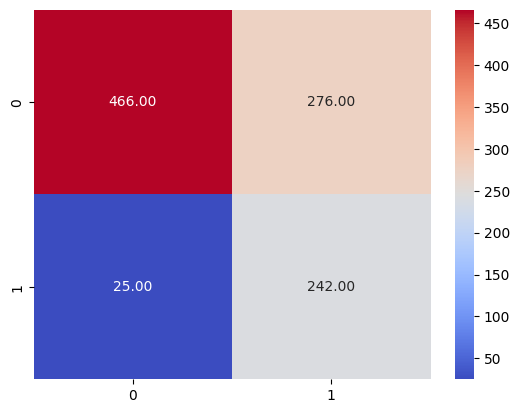

In [100]:
threshold = 0.180801

y_pred_proba = log_pipeline.predict_proba(X_eval)[:,1]

binary_predictions = (y_pred_proba > threshold).astype(int)
threshold_matrix = confusion_matrix(y_eval_encoded, binary_predictions)

# plot heat map of threshold conf_matrix
sns.heatmap(threshold_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')

#### Training Models on a Balanced Data Set

In [101]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

balanced_data_models =[
    ('Decision_tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic_reg', LogisticRegression(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('random_forest', RandomForestClassifier(random_state = 42))
]

# Creating dictionary for the models
balanced_data_all_pipelines = {}

# Create an empty DataFrame for metrics
balanced_data_metrics_table = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall', 'f1_score'])

# Loop over models and create pipelines, fit models, and calculate metrics
for model_name, classifier in models:
    balanced_data_final_pipeline = imbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote_sampler', SMOTE(random_state =42)),
        ('classifier', classifier)
    ])
    
    # Fit the pipeline on training data
    balanced_data_final_pipeline.fit(X_train, y_train_encoded)
    
    # Make predictions on the evaluation dataset
    y_pred = balanced_data_final_pipeline.predict(X_eval)
    
    # Calculate classification report metrics
    balanced_data_metrics = classification_report(y_eval_encoded, y_pred, output_dict=True)

    # Add all pipelines into balanced_data_all_pipelines
    balanced_data_all_pipelines[model_name] = balanced_data_final_pipeline
    
    # Extract metrics for the current model
    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1_score = metrics['weighted avg']['f1-score']
    
    # Add metrics to metrics_table
    balanced_data_metrics_table.loc[len(balanced_data_metrics_table)] = [model_name, accuracy, precision, recall, f1_score]

# Display the metrics table
balanced_data_metrics_table.sort_values(ascending=False, by='f1_score')

,model_name,accuracy,precision,recall,f1_score
0,Decision_tree,0.786918,0.776866,0.786918,0.779906
1,Logistic_reg,0.786918,0.776866,0.786918,0.779906
2,knn,0.786918,0.776866,0.786918,0.779906
3,random_forest,0.786918,0.776866,0.786918,0.779906


The models performed better on the imbalanced dataset so we will use the imbalanced dataset for evaluation and hyperparameter tuning

### Hyperparameter Tuning

In [102]:
# Define the hyperparameters to search

param_grids = {

    'Decision_tree': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },

    'Logistic_reg': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],        
        'classifier__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'classifier__max_iter': [300]
    },

    'knn': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11]
    },

    'random_forest': {
        'classifier__n_estimators': [10, 50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30]
    } 

    }


params = {}
search_histories = {}

for model_name, classifier in models:
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(
        estimator = final_pipeline, 
        param_grid = param_grid, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
        scoring = ['f1_weighted', 'precision', 'recall'],
        refit = 'f1_weighted',
        verbose = 3, 
        n_jobs = -1
    )
    grid_search.fit(X_train, y_train_encoded)
    params[model_name] = grid_search
        
    search_history = pd.DataFrame(grid_search.cv_results_)        
    search_histories[model_name] = search_history

for model_name, grid_search in params.items():
    print(f'Best hyperparamters for {model_name}:{grid_search.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparamters for Decision_tree:{'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Best hyperparamters for Logistic_reg:{'classifier__C': 0.1, 'classifier__max_iter': 300, 'classifier__solver': 'newton-cg'}
Best hyperparamters for knn:{'classifier__n_neighbors': 11}
Best hyperparamters for random_forest:{'classifier__max_depth': 10, 'classifier__n_estimators': 200}


In [103]:
# Get the models with the best hyperparameters
def get_best_models(params):
    best_models = []
    for model_name, grid_search in params.items():
        best_model = grid_search.best_estimator_
        best_models.append((model_name, best_model))    
    
    return best_models
 
best_models = get_best_models(params)

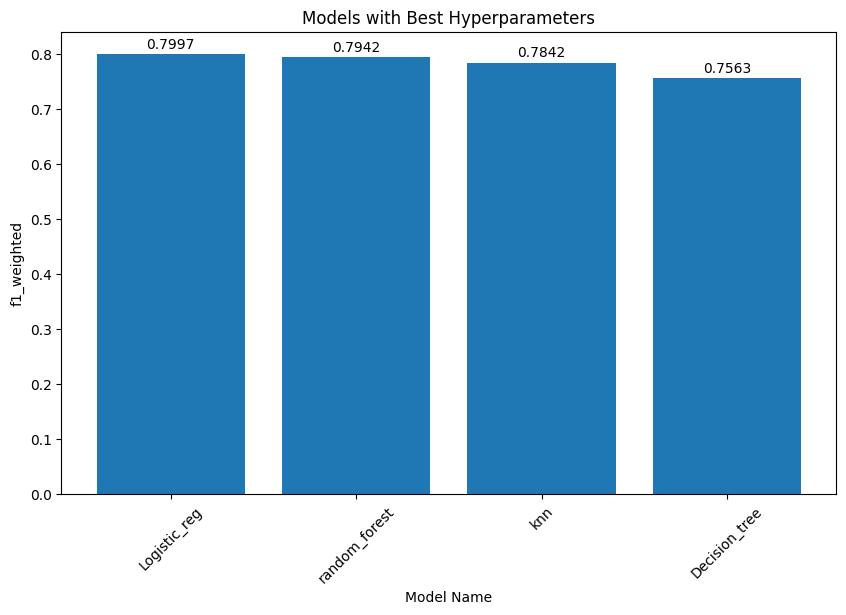

In [104]:
# Get models f1_weighted scores and names
model_names = [model_name for model_name in search_histories.keys()]
model_scores = [search_history['mean_test_f1_weighted'].max() for search_history in search_histories.values()]

# Create a DataFrame to for plot
df_models = pd.DataFrame({'model_name': model_names, 'f1_score': model_scores})
df_models = df_models.sort_values(by='f1_score', ascending=False)


# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(data=df_models, x='model_name', height='f1_score')

# Add text labels to the bars
for i, score in enumerate(df_models['f1_score']):
    plt.text(i, score+0.01, '{:1.4f}'.format(score), ha="center")

plt.xlabel('Model Name')
plt.ylabel('f1_weighted')
plt.title('Models with Best Hyperparameters')
plt.xticks(rotation=45)
plt.show()

In [105]:
metric_before_after_tuning_models = pd.merge(
    metrics_table[['model_name', 'f1_score']], 
    df_models, 
    on='model_name', 
    how='inner', 
    suffixes=('_before', '_after')
).sort_values(ascending=False, by='f1_score_after')

metric_before_after_tuning_models

,model_name,f1_score_before,f1_score_after
1,Logistic_reg,0.796963,0.799653
3,random_forest,0.779906,0.794231
2,knn,0.764687,0.784230
0,Decision_tree,0.727303,0.756317


#### Compare models before and after hyperparameter tuning using f1 score (weighted) metric

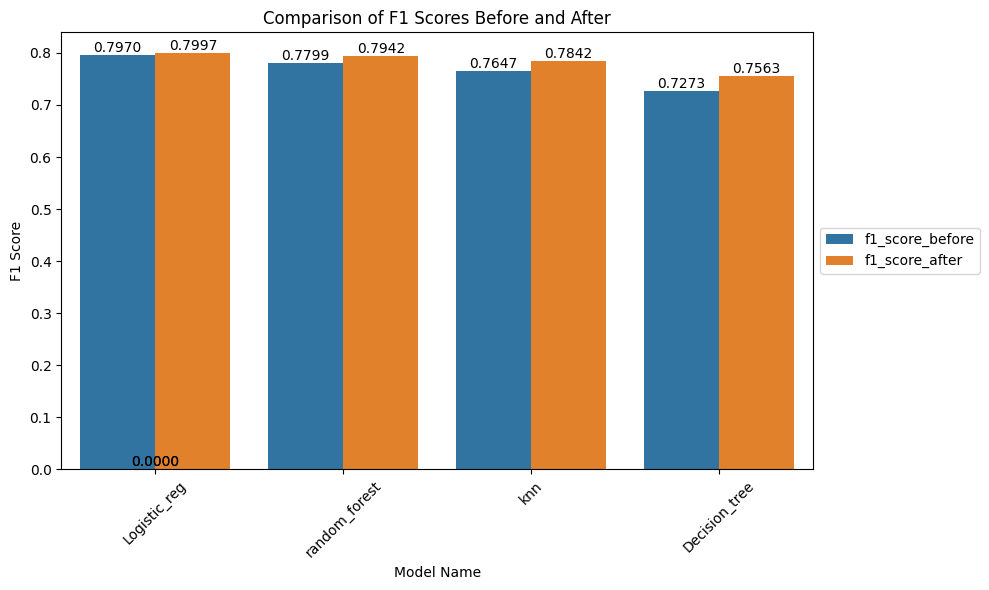

In [106]:
# Melt the DataFrame to combine f1_score_before and f1_score_after into a single column
metric_melted = metric_before_after_tuning_models.melt(id_vars='model_name', var_name='score_type', value_name='f1_score')

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the combined data
ax = sns.barplot(data=metric_melted, x='model_name', y='f1_score', hue='score_type')
plt.title('Comparison of F1 Scores Before and After')
plt.xlabel('Model Name')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

# Annotate the values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')
    
# Move legend to the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Feature importances visualizations

In [107]:
best_model_name = df_models['model_name'].iloc[0]
best_model = dict(best_models).get(best_model_name)
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat-encoder',
                                                                   OneH...re'))]),
                                                  Index(['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=300, random_state=42,
                                    solver='newton-cg'))])

#### Evaluate the best model on the evaluation set

In [108]:
y_eval_pred = best_model.predict(X_eval)
print(f'Classification report of the best model- {best_model_name}\n\n{classification_report(y_true=y_eval_encoded, y_pred=y_eval_pred)}')

Classification report of the best model- Logistic_reg

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       742
           1       0.64      0.57      0.60       267

    accuracy                           0.80      1009
   macro avg       0.74      0.73      0.73      1009
weighted avg       0.79      0.80      0.80      1009



#### Prepare the test dataset

In [109]:
test_df = pd.read_excel('Data/Telco-churn-last-2000.xlsx')

In [110]:
test_df.drop('customerID', axis=1, inplace =True)

In [111]:
test_df.columns = test_df.columns.str.lower()


In [112]:
# test_df['totalcharges'] = test_df['totalcharges'].
test_df['totalcharges'] = pd.to_numeric(test_df['totalcharges'], errors = 'coerce')

In [113]:
train_df.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,Male,0,No,No,45,No,NaN,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


#### Using the Test Data to test our model and predict churn of customers

In [114]:
predicted_churn = best_model.predict(test_df)
predicted_churn

array([1, 0, 0, ..., 1, 0, 0])

In [115]:
# Create an array of corresponding labels
labels = np.array(['No', 'Yes']) # Index 0 is No, 1 is Yes
test_df['predicted_churn'] = labels[predicted_churn]

In [116]:
test_df.head(2)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,predicted_churn
0,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55,Yes
1,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80,No


### Visualize the predicted churn

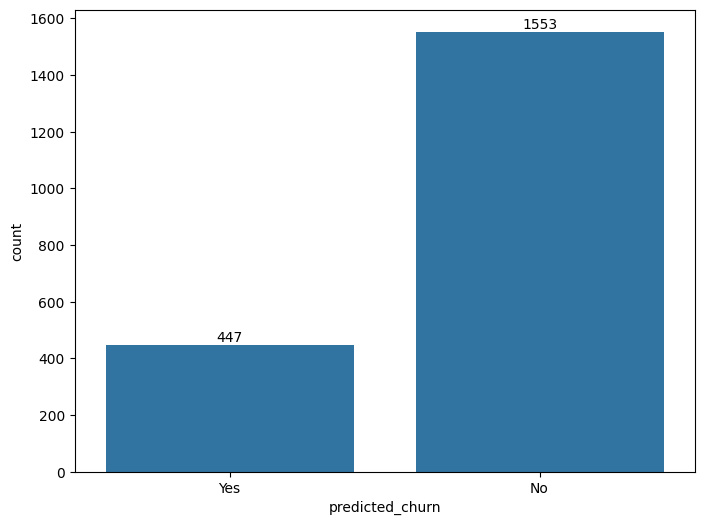

In [117]:
# Create the figure
plt.figure(figsize=(8, 6))

ax=sns.countplot(test_df, x='predicted_churn')

# Add count values on top of each bar
for p in ax.patches:
    count = int(p.get_height())  # Convert count to integer
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

#### Persist/Saving the Model

In [119]:
import joblib

for model_name, pipeline in all_pipelines.items():
    joblib.dump(model_name,f'./Trained models/{model_name}.joblib')

    joblib.dump(encoder,f'./Trained models/encoder.joblib')

                                                